# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [3]:
import numpy as np
from numpy import savetxt
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import re, itertools
import string
from collections import OrderedDict
from operator import itemgetter
import time
import gzip

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# keras imports
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding

# nltk
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('stopwords')

# text cleanup
# from pattern.en import suggest
import enchant
from enchant.checker import SpellChecker
from spellchecker import SpellChecker

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('data/reviews_Video_Games_5.json.gz')

In [15]:
len(df)

231780

In [11]:
desired_cols = ['reviewText', 'overall']
df = df[desired_cols].rename(columns={'reviewText': 'review'})
df.head()

,review,overall
0,Installing the game was a struggle (because of...,1.0
1,If you like rally cars get this game you will ...,4.0
2,1st shipment received a book instead of the ga...,1.0
3,"I got this version instead of the PS3 version,...",3.0
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0


# Percentile graphing below -- it takes a very long time to run?

28171


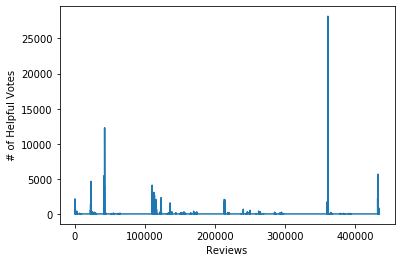

In [ ]:
# perc = np.percentile(df['helpful'], 99) #10,25,50,75,90
d = df['helpful']
print(np.max(df['helpful']))
p = np.linspace(90, 100, 10)
# p = [10.0,25.0,50.0,75.0,90.0]
perc = np.percentile(d, p)

plt.plot(d)
plt.ylabel('# of Helpful Votes')
plt.xlabel('Reviews')
plt.show()

fig = plt.figure()
ax = plt.axes()
ax.plot(p, perc)
plt.ylabel('# of Votes')
plt.xlabel('Percentile')

rec = df['recommendation']
yes = df['recommendation'].sum()
no = len(df['recommendation']) - yes
print(yes)
print(no)

x = ("Recommended", "Not Recommended")
y = [yes, no]
fig2 = plt.figure()

plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('# of Reviews')
plt.show()

fig3 = plt.figure()

# remove nan reviews

In [12]:
orig_len = len(df)
df.dropna(axis=0, inplace=True)
print ('dropped {} nan reviews'.format(orig_len - len(df)))

dropped 0 nan reviews


In [13]:
table = str.maketrans('', '', string.punctuation)
len(table)

32

# Moved the below code after removing nan reviews, also refactored for speed

In [14]:
r = df["review"].tolist()
r1 = []
for i in range(len(r)):
    word_len = len(r[i].split(" "))
    r1.append(word_len)
print (np.mean(r1))
print (np.sum(r1))

208.6613124514626
48363519


# Only keep reviews <= 300 words
* Need to calculate 10th, 25th, 50th, 75th, 90th percentile of helpful/funny votes on the removed reviews to unders

In [11]:
# remove reviews over a limit
removed_idx = []
for i in range(len(df)):
    review = df.iloc[i].review
    words = review.split(" ")
    if len(words) > 200: 
        removed_idx.append(i)


df.drop(df.index[removed_idx], inplace=True)
print ("removed {} reviews > 200 words".format(len(removed_idx)))

removed 15916 reviews > 200 words


# Clean up textual data (try this stuff later, do vanilla run first)
* Remove common stopwords?
* Lower case everything 
* All ‘s in the data is preceded by a ‘\’ which should be cleaned out
* Maybe don't lower case everything... ex: 
    * "I HIGHLY RECOMMEND THIS GAME CAUSE THERE ARE SOME KILLERS WILL FOLLOW YOU NO MATTER WHERE YOU GO IN WHICH YOU'LL GO LOOPING EACH OTHER Who said this game is a horror game but MEHHHH Lieesssss ahhahahaha xDDDI never laugh so hard cause of this game I LOVE IT &lt 3333"

In [16]:
subset_reviews = df['review'].tolist()

In [17]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [18]:
lemmatizer = WordNetLemmatizer() 
cleaned_reviews = []
remove_rows = []
stop_words = set(stopwords.words('english'))

orig_len = len(df)
start_time = time.time()
for i, each_review in enumerate(subset_reviews):
    each_cleaned_review = []
    words = each_review.split(" ")
    for idx, each_word in enumerate(words):
        encoded_text = each_word.encode('utf8')
        if "\\" in str(encoded_text):
            remove_rows.append(i)
            break
        cleaned = each_word.replace("(", "").replace(")", "") # remove ()
        if "." in cleaned:
            if cleaned.split(".")[1] not in ["", "'"]:
                cleaned = cleaned.replace(".", ". ") # add space after "." 
        cleaned = cleaned.translate(table).lower()
        cleaned = reduce_lengthening(cleaned)
        if len(cleaned) != 0 and cleaned not in stop_words:
            #figure out how to stop empty strings
            cleaned = lemmatizer.lemmatize(cleaned)
            each_cleaned_review.append(cleaned)
    cleaned_reviews.append(" ".join(each_cleaned_review))
    if len(each_cleaned_review) == 0:
        remove_rows.append(i)

cleaned_reviews = [i for j, i in enumerate(cleaned_reviews) if j not in remove_rows]
df.drop(df.index[remove_rows], inplace=True)
print ("Removed {} rows".format(orig_len - len(df)))
print ("time took: ".format(time.time() - start_time))
print(cleaned_reviews)

Removed 2664 rows
time took: 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
print (len(cleaned_reviews))
print (len(df))

229116
229116


In [16]:
# this cell takes ~20 minutes to run
unknowns = {} 
chkr = enchant.checker.SpellChecker("en_EN")

start_time = time.time()

for i, review in enumerate(cleaned_reviews):
    if i % 50000 == 0:
        print("Took {} for 50000 reviews ".format(time.time() - start_time))
        start_time = time.time()
    each_cleaned_review = []
    words = review.split(" ")
    for idx, each_word in enumerate(words):
        if len(each_word) == 0: # to handle double spaces
            continue
        if not chkr.check(each_word):
            if not chkr.check(each_word[0].upper()+each_word[1:]): # check proper nouns
                if each_word not in unknowns.keys():
                    unknowns[each_word] = 1
                else:
                    unknowns[each_word] = unknowns[each_word] + 1

common_unknowns = OrderedDict(sorted(unknowns.items(), key = itemgetter(1), reverse = True))

# print(common_unknowns[0:20])

Took 0.0 for 50000 reviews 
Took 122.76657271385193 for 50000 reviews 
Took 80.91164016723633 for 50000 reviews 
Took 116.180330991745 for 50000 reviews 
Took 101.59243750572205 for 50000 reviews 
Took 126.44805026054382 for 50000 reviews 
Took 106.41717910766602 for 50000 reviews 
Took 108.37420415878296 for 50000 reviews 
Took 109.36903429031372 for 50000 reviews 


In [17]:
common_unknowns = OrderedDict(sorted(unknowns.items(), key = itemgetter(1), reverse = True))

# print(common_unknowns)

In [18]:
print(len(common_unknowns))

139445


In [20]:
slang_dict = {}
with open("data/slangdict.txt") as f:
    for line in f:
        slang = line.split("-")
        if len(slang) > 1:
            key = slang[0].strip().translate(table).lower()
            val = slang[1].strip().translate(table).lower()
            slang_dict[key] = val
# print(slang_dict)

In [21]:
word_count_dict = {}
for i, review in enumerate(cleaned_reviews):
    if i% 50000 == 0:
        print ("For 50000, took {} seconds".format(time.time() - start_time))
        start_time = time.time()
    words = review.split(" ")
    for idx, each_word in enumerate(words):
        if each_word not in word_count_dict.keys():
            word_count_dict[each_word] = 1
        else:
            word_count_dict[each_word] += 1

For 50000, took 320.77851033210754 seconds
For 50000, took 2.9012410640716553 seconds
For 50000, took 2.58309268951416 seconds
For 50000, took 2.5771076679229736 seconds
For 50000, took 2.3776419162750244 seconds


### For steam dataset, set count to < 10 for 15K word dictionary size
### For AMZN dataset, set count to < 100 for 10K word dictionary size

In [27]:
spell = SpellChecker(distance=1)
final_cleaned_reviews = []
unk_counter = 0

start_time = time.time()
for i, review in enumerate(cleaned_reviews):
    if i% 50000 == 0:
        print ("For 50000, took {} seconds".format(time.time() - start_time))
        start_time = time.time()
    each_cleaned_review = []
    words = review.split(" ")
    for idx, each_word in enumerate(words):
        if word_count_dict[each_word] < 100:
            words[idx] = 'UNK'
#         if each_word in unknowns.keys():
#             if unknowns[each_word] < 10000000: #trying to cut down words
#                 if each_word in slang_dict.keys():
#                     continue
#                 w1 = spell.correction(each_word)
#                 if w1 != each_word:
#                     words[idx] = w1
#                 else:
#                 words[idx] = 'UNK'
#                 unk_counter+=1
                    
    final_cleaned_reviews.append((" ".join(words)))

For 50000, took 0.0 seconds
For 50000, took 1.663550615310669 seconds
For 50000, took 1.6246168613433838 seconds
For 50000, took 1.6316766738891602 seconds
For 50000, took 1.533860445022583 seconds


In [29]:
# find out vocab size after this cleaning portion
word_set = {}
for each_review in final_cleaned_reviews:
    word_list = each_review.split(" ")
    for each_word in word_list:
        word_set[each_word] = 1

In [30]:
# cleaned vocab size
# 1K min word count --> 38K vocab size
# 2k min word count --> 38k vocab size
# 10K min word count --> 30K

#amzn dataset, 10 --> 37K


len(word_set.keys())

10746

In [31]:
len(word_set)

10746

# todo spellcheck

In [ ]:
len(df)

In [91]:
len(final_cleaned_reviews)

405671

In [32]:
df['cleaned_reviews'] = final_cleaned_reviews

# tf-idf below

In [ ]:
raw_text = test_drop['review']
vectorizer = TfidfVectorizer(use_idf=True)
vectors = vectorizer.fit_transform(raw_text.apply(lambda x: np.str_(x))) #.apply(lambda x: np.str_(x))

# X_as_array = X.toarray()
# use this line of code to verify that the numpy array represents the same number of documents that we have in the file list
# print(len(X_as_array))

feature_names = vectorizer.get_feature_names()

In [ ]:
# dense = vectors.todense()
vectorlist = vectors.tolist()
tf_idf = pd.DataFrame(vectorlist, columns=feature_names)

In [ ]:
print(vectors.shape)
print(feature_names)

**Ben's Date Stuff**

In [92]:
newColumns = df["date_posted"].str.split("-", n = 2, expand = True) 

In [93]:
df['Year'] = newColumns[0]
df['Month'] = newColumns[1]
df['Day'] = newColumns[2]
df.drop(columns = ['date_posted'], inplace = True)

df.head()

,funny,helpful,hour_played,is_early_access_review,recommendation,review,title_ACE COMBAT™ 7: SKIES UNKNOWN,title_ARK: Survival Evolved,title_ASTRONEER,title_Battlefleet Gothic: Armada 2,...,title_Terraria,title_The Elder Scrolls V: Skyrim Special Edition,title_Tom Clancy's Rainbow Six® Siege,title_Wallpaper Engine,title_Wargroove,"title_Warhammer 40,000: Mechanicus",cleaned_reviews,Year,Month,Day
0,2,4,578,0,1,&gt Played as German Reich&gt Declare war on B...,0,0,0,0,...,0,0,0,0,0,0,gt played german UNK declare war UNK cant brea...,2019,02,10
1,0,0,184,0,1,yes.,0,0,0,0,...,0,0,0,0,0,0,yes,2019,02,10
2,0,0,892,0,1,Very good game although a bit overpriced in my...,0,0,0,0,...,0,0,0,0,0,0,good game although bit overpriced opinion id p...,2019,02,07
7,295,219,71,0,1,I have never been told to kill myself more tha...,0,0,0,0,...,0,0,0,0,0,0,never told kill playing game,2018,12,24
9,380,271,414,0,1,if you think cs go is toxic try this game,0,0,0,0,...,0,0,0,0,0,0,think c go toxic try game,2018,12,05


# Encoding text below - steam dataset currently at 194 embedding dim, need to keep same

In [34]:
# remove reviews over a limit
removed_idx = []
for i in range(len(df)):
    review = df.iloc[i].cleaned_reviews
    words = review.split(" ")
    if len(words) > 194:
        removed_idx.append(i)


df_ = df.drop(df.index[removed_idx])
print ("removed {} reviews > 194 words".format(len(removed_idx)))

removed 35352 reviews > 194 words


In [35]:
VOCAB_SIZE = None
MAX_SEQ_LEN = 0

# find vocab_size
all_words = {}
for each_review in df_.cleaned_reviews.tolist():
    word_list = each_review.split(" ")
    # find max seq len
    if len(word_list) > MAX_SEQ_LEN:
        MAX_SEQ_LEN = len(word_list)
        sent = word_list

    for ea_word in word_list:
        if ea_word in all_words:
            all_words[ea_word] += 1
        else:
            all_words[ea_word] = 1
VOCAB_SIZE = len(all_words.keys())
print ('vocab_size = ', VOCAB_SIZE)
print ('max_seq_len = ', MAX_SEQ_LEN)
# print (MAX_SEQ_LEN, sent)
# vocab_size =  52716
# max_seq_len =  7984

vocab_size =  10746
max_seq_len =  194


In [36]:
final_cleaned_reviews = df_.cleaned_reviews.tolist()

In [37]:
encoded_reviews = [one_hot(x, VOCAB_SIZE) for x in final_cleaned_reviews]
padded_reviews = pad_sequences(encoded_reviews, maxlen=MAX_SEQ_LEN, padding='pre')
padded_reviews.shape

(193764, 194)

In [39]:
encoded_text_cols = padded_reviews.shape[1]
for col_idx in range(encoded_text_cols):
    df_.insert(len(df_.columns), "encoded_{}".format(col_idx+1), padded_reviews[:, col_idx])
df_.head()

,review,overall,cleaned_reviews,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5,encoded_6,encoded_7,...,encoded_185,encoded_186,encoded_187,encoded_188,encoded_189,encoded_190,encoded_191,encoded_192,encoded_193,encoded_194
0,Installing the game was a struggle (because of...,1.0,installing game struggle game window live bugs...,0,0,0,0,0,0,0,...,4059,9289,8594,9289,4934,7474,3382,652,2097,2876
1,If you like rally cars get this game you will ...,4.0,like rally car get game fun it oriented UNK UN...,0,0,0,0,0,0,0,...,3340,8561,9289,214,5126,6257,2827,6823,1256,8798
2,1st shipment received a book instead of the ga...,1.0,1st shipment received book instead game 2nd sh...,0,0,0,0,0,0,0,...,1745,5242,506,2434,7599,8764,5242,7146,6949,3506
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,dirt 2 xbox 360 okay game started playing game...,0,0,0,0,0,0,0,...,7514,5853,5815,9606,595,8561,243,2076,2734,9289
5,"Overall this is a well done racing game, with ...",4.0,overall well done racing game good graphic tim...,0,0,0,0,0,0,0,...,8375,3595,1356,2298,8561,7502,2298,1329,6555,6758


In [40]:
df_.shape

(193764, 197)

# Convert to classification problem

In [42]:
df_['overall'] = ((df_['overall']<=5) & (df_['overall']>=4)).astype(int)

In [43]:
df_.head()

,review,overall,cleaned_reviews,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5,encoded_6,encoded_7,...,encoded_185,encoded_186,encoded_187,encoded_188,encoded_189,encoded_190,encoded_191,encoded_192,encoded_193,encoded_194
0,Installing the game was a struggle (because of...,0,installing game struggle game window live bugs...,0,0,0,0,0,0,0,...,4059,9289,8594,9289,4934,7474,3382,652,2097,2876
1,If you like rally cars get this game you will ...,1,like rally car get game fun it oriented UNK UN...,0,0,0,0,0,0,0,...,3340,8561,9289,214,5126,6257,2827,6823,1256,8798
2,1st shipment received a book instead of the ga...,0,1st shipment received book instead game 2nd sh...,0,0,0,0,0,0,0,...,1745,5242,506,2434,7599,8764,5242,7146,6949,3506
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,1,dirt 2 xbox 360 okay game started playing game...,0,0,0,0,0,0,0,...,7514,5853,5815,9606,595,8561,243,2076,2734,9289
5,"Overall this is a well done racing game, with ...",1,overall well done racing game good graphic tim...,0,0,0,0,0,0,0,...,8375,3595,1356,2298,8561,7502,2298,1329,6555,6758


# Code below is to save cleaned dataset -- don't edit

In [44]:
def save_cleaned_dataset(final_df):
    # dataset must be a pd dataframe
    root = "data/"
    final_df.to_csv(root + "cleaned_amzn_data_4-15_10Kwords.csv")
save_cleaned_dataset(df_) # testing

In [ ]:
def save_cleaned_dataset(dataset):
    # dataset must be a np array
    root = "data/"
    cols_added = dataset.shape[1]
    col_names = []
    for col_idx in range(cols_added):
        col_names.append("embedded_{}".format(col_idx))
    dataset_df = pd.DataFrame(data=dataset, columns=col_names)
    dataset_df.to_csv("steam_text_data_4-15.csv")
#     savetxt(root + 'cleaned_steam_data_3-28.csv', dataset, delimiter=',')
save_cleaned_dataset(padded_reviews) # testing